# Actividades

1. Implementar y ejecutar el algoritmo SARSA en "*The Cliff*".

2. Implementar y ejecutar el algoritmo *Q-Learning* en "*The Cliff*". ¿Cómo converge con respecto a SARSA? ¿A qué se debe? Comentar.

3. Ejecutando con distintos híper-parámetros, realizar una breve descripción sobre cómo afectan a la convergencia los distintos valores de $\alpha$, $\epsilon$ y $\gamma$.

4. (Opcional) Implementar política de exploración **Softmax**, en donde cada acción tiene una probabilidad:

<center>

$$ \pi(a \mid s) = \frac{e^{Q(s,a)/\tau}}{\sum_{\widetilde{a} \in A}e^{Q(s,\widetilde{a})/\tau}} $$

</center>


5. (Opcional) Implementar *Dyna-Q* a partir del algoritmo *Q-Learning*, incorporando una actualización mediante un modelo. Comentar cómo se desempeña respecto a los demás algoritmos.

Para dejar el lab listo para su corrección, dejar link a repo de Github con un notebook ejecutando el agente en la planilla enviada en Slack.




# 1. Definición del entorno *The Cliff*

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import random

class CliffEnvironment:
    def __init__(self):
        self.rows = 4
        self.cols = 12
        self.start = (3, 0)
        self.goal  = (3, 11)
        self.cliff = [(3, c) for c in range(1, 11)]
        self.reset()
    def render(self, ax, agent_pos=None):
        if agent_pos is None:
            agent_pos = self.agent

        ax.clear()
        ax.set_xlim(0, self.cols)
        ax.set_ylim(0, self.rows)
        ax.set_xticks(range(self.cols+1))
        ax.set_yticks(range(self.rows+1))
        ax.grid(True)

        # Dibujar acantilado
        for (r, c) in self.cliff:
            ax.add_patch(plt.Rectangle((c, self.rows - r - 1), 1, 1, color="black"))

        # Dibujar inicio
        sr, sc = self.start
        ax.add_patch(plt.Rectangle((sc, self.rows - sr - 1), 1, 1, color="green"))

        # Dibujar meta
        gr, gc = self.goal
        ax.add_patch(plt.Rectangle((gc, self.rows - gr - 1), 1, 1, color="gold"))

        # Dibujar agente
        ar, ac = agent_pos
        ax.plot(ac + 0.5, self.rows - ar - 0.5, "bo", markersize=12)

        ax.set_title("CliffWalking")
        ax.set_aspect("equal")


    def reset(self):
        self.agent = self.start
        return self.to_state(self.agent)

    def to_state(self, pos):
        r, c = pos
        return r * self.cols + c

    def step(self, action):
        r, c = self.agent
        # 0: up, 1: right, 2: down, 3: left
        if action == 0: r -= 1
        elif action == 1: c += 1
        elif action == 2: r += 1
        elif action == 3: c -= 1

        r = np.clip(r, 0, self.rows - 1)
        c = np.clip(c, 0, self.cols - 1)
        new_pos = (r, c)

        if new_pos in self.cliff:
            reward = -100
            new_pos = self.start
            done = False # En Cliff walking standard suele no terminar, solo resetea pos.
                         # Si tu versión termina, pon done=True
        elif new_pos == self.goal:
            reward = 0
            done = True
        else:
            reward = -1
            done = False
        
        self.agent = new_pos
        return self.to_state(new_pos), reward, done

In [26]:
env = CliffEnvironment()

# 2. Implementación de SARSA y Q-Learning

In [27]:
# Política Epsilon-Greedy
def epsilon_greedy(Q, state, epsilon):
    if random.uniform(0, 1) < epsilon:
        return random.randint(0, 3)
    else:
        # np.argmax puede romper empates siempre con el primero, 
        return np.argmax(Q[state])

# Algoritmo SARSA
def sarsa(env, episodes=500, alpha=0.5, gamma=1.0, epsilon=0.1):
    Q = np.zeros((env.rows * env.cols, 4))
    rewards = []
    
    for _ in range(episodes):
        state = env.reset()
        action = epsilon_greedy(Q, state, epsilon)
        total_reward = 0
        done = False
        
        while not done:
            next_state, reward, done = env.step(action)
            next_action = epsilon_greedy(Q, next_state, epsilon)
            
            # Actualización SARSA: Q(s,a) + alpha * [r + gamma*Q(s',a') - Q(s,a)]
            Q[state, action] += alpha * (reward + gamma * Q[next_state, next_action] - Q[state, action])
            
            state = next_state
            action = next_action
            total_reward += reward
            
            if total_reward < -1000: break # Evitar bucles infinitos al inicio
            
        rewards.append(total_reward)
    return Q, rewards

# Algoritmo Q-Learning
def q_learning(env, episodes=500, alpha=0.5, gamma=1.0, epsilon=0.1):
    Q = np.zeros((env.rows * env.cols, 4))
    rewards = []
    
    for _ in range(episodes):
        state = env.reset()
        total_reward = 0
        done = False
        
        while not done:
            action = epsilon_greedy(Q, state, epsilon)
            next_state, reward, done = env.step(action)
            
            # Actualización Q-Learning: Q(s,a) + alpha * [r + gamma*max_a(Q(s',a)) - Q(s,a)]
            best_next_action = np.argmax(Q[next_state])
            Q[state, action] += alpha * (reward + gamma * Q[next_state, best_next_action] - Q[state, action])
            
            state = next_state
            total_reward += reward
            
            if total_reward < -1000: break
            
        rewards.append(total_reward)
    return Q, rewards

In [28]:
# Función para suavizar curvas (Moving Average)
def moving_average(data, window_size=50):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

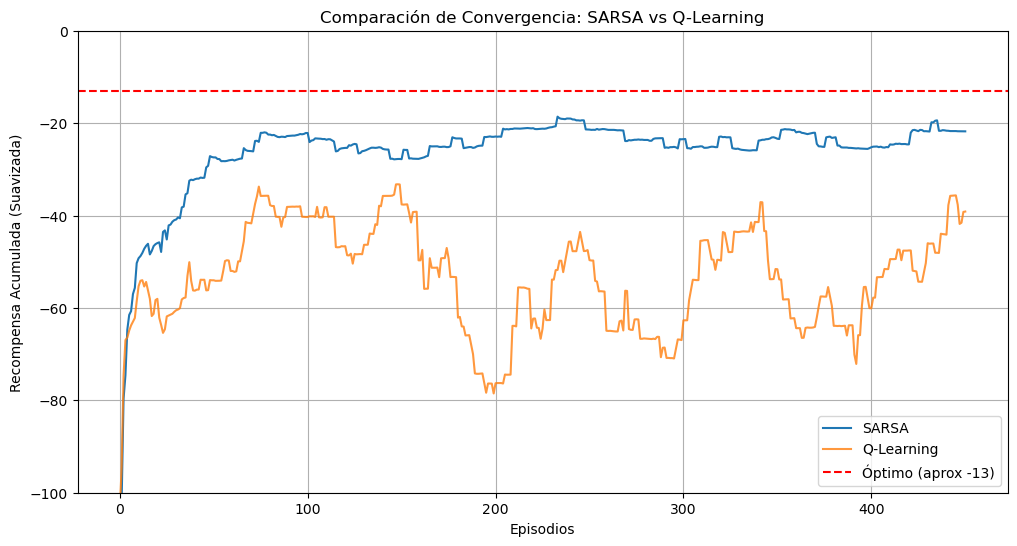

In [29]:
# Parámetros base
episodes = 500
alpha = 0.5
gamma = 1.0
epsilon = 0.1

# Ejecución de SARSA
Q_sarsa, rewards_sarsa = sarsa(env, episodes, alpha, gamma, epsilon)

# Ejecuación de Q-Learning
Q_qlearning, rewards_qlearning = q_learning(env, episodes, alpha, gamma, epsilon)

# --- GRAFICAR RESULTADOS ---
plt.figure(figsize=(12, 6))
plt.plot(moving_average(rewards_sarsa), label='SARSA')
plt.plot(moving_average(rewards_qlearning), label='Q-Learning', alpha=0.8)
plt.axhline(y=-13, color='r', linestyle='--', label='Óptimo (aprox -13)')
plt.title('Comparación de Convergencia: SARSA vs Q-Learning')
plt.xlabel('Episodios')
plt.ylabel('Recompensa Acumulada (Suavizada)')
plt.legend()
plt.ylim(-100, 0) # Hacemos zoom en la parte interesante
plt.grid(True)
plt.show()

## Análisis de convergencia 


- SARSA, al ser un algoritmo *On-Policy* aprende una política más conservadora (va por el "camino seguro") alejándose del borde del acantilado, ya que tiene en cuenta que su política exploratoria podría hacerlo caer. Q-Learning (Off-Policy) aprende la ruta óptima pegada al borde, ya que asume que siempre tomará la mejor acción futura (max Q), ignorando el riesgo de la exploración.

- Convergencia: Q-Learning puede converger a una política que, durante el entrenamiento (con $\epsilon$ > 0), resulte en peores recompensas acumuladas promedio porque el agente cae frecuentemente al acantilado al intentar seguir el camino óptimo "peligroso". SARSA obtiene mejores recompensas durante el entrenamiento pero su camino final no resulta óptimo en términos de pasos, porque en general toma un camino más largo.

# 3 . Analisis de Hiperparámetros

## SARSA

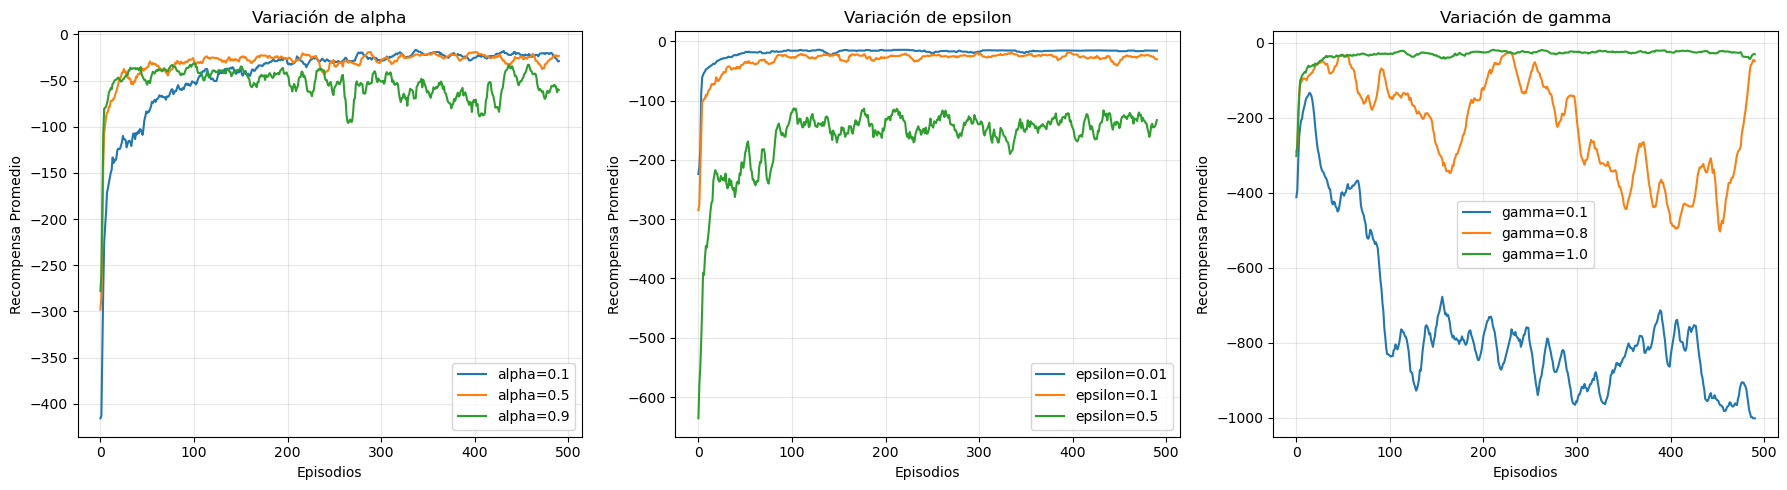

In [30]:
def plot_parameter_sweep(ax, env, algorithm, param_name, param_values, 
                         fixed_params, episodes=500, runs=10):
    """
    Realiza un barrido de un hiperparámetro específico en un eje dado (subplot).
    """
    for value in param_values:
        all_rewards = np.zeros(episodes)

        # Promediamos sobre varias corridas
        for r in range(runs):
            current_params = fixed_params.copy()
            current_params[param_name] = value
            current_params['episodes'] = episodes

            _, rewards = algorithm(env, **current_params)
            all_rewards += np.array(rewards)

        avg_rewards = all_rewards / runs

        # Suavizado
        window = 10
        smoothed_rewards = np.convolve(avg_rewards, np.ones(window)/window, mode='valid')

        ax.plot(smoothed_rewards, label=f'{param_name}={value}')

    ax.set_title(f'Variación de {param_name}')
    ax.set_xlabel('Episodios')
    ax.set_ylabel('Recompensa Promedio')
    ax.grid(True, alpha=0.3)
    ax.legend()


# =============================
#        EJECUCIÓN 1x3
# =============================

base_params = {
    'alpha': 0.5,
    'gamma': 1.0,
    'epsilon': 0.1
}

env = CliffEnvironment()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Barrido de ALPHA
plot_parameter_sweep(
    axes[0], env, sarsa,
    'alpha', [0.1, 0.5, 0.9],
    base_params
)

# 2. Barrido de EPSILON
plot_parameter_sweep(
    axes[1], env, sarsa,
    'epsilon', [0.01, 0.1, 0.5],
    base_params
)

# 3. Barrido de GAMMA
plot_parameter_sweep(
    axes[2], env, sarsa,
    'gamma', [0.1, 0.8, 1.0],
    base_params
)

plt.tight_layout()
plt.show()


## *q-learning*

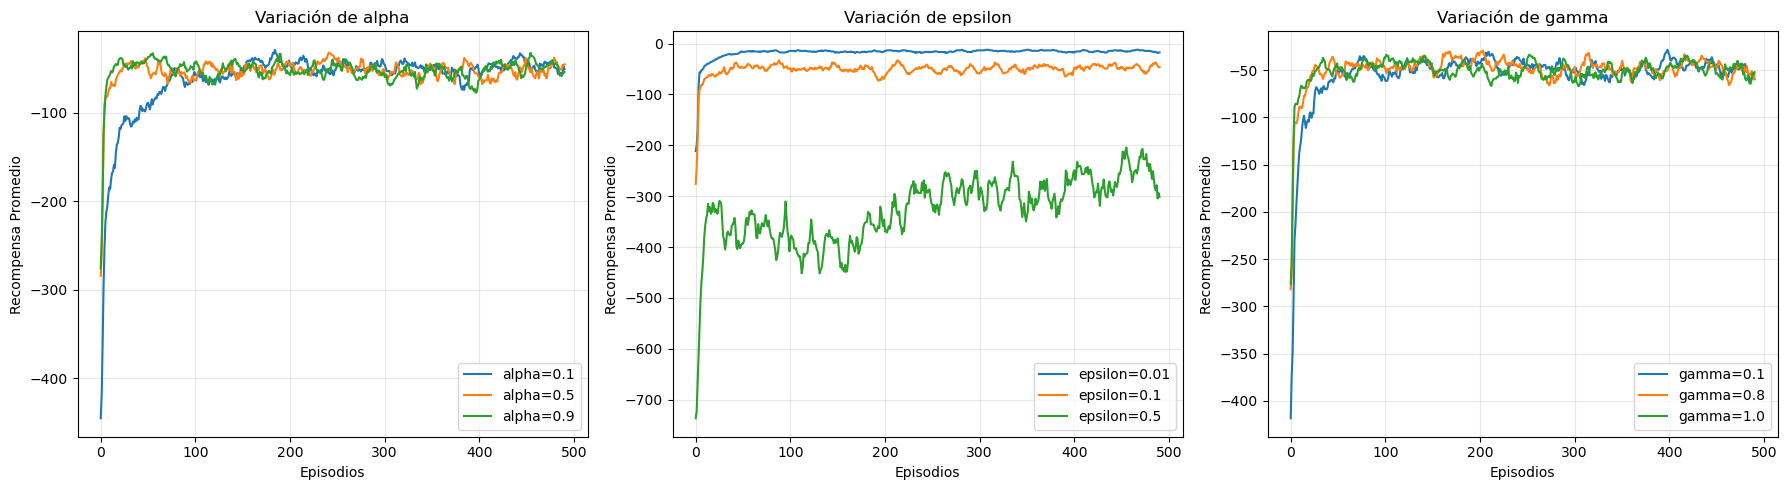

In [31]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Barrido de ALPHA
plot_parameter_sweep(
    axes[0], env, q_learning,
    'alpha', [0.1, 0.5, 0.9],
    base_params
)

# 2. Barrido de EPSILON
plot_parameter_sweep(
    axes[1], env, q_learning,
    'epsilon', [0.01, 0.1, 0.5],
    base_params
)

# 3. Barrido de GAMMA
plot_parameter_sweep(
    axes[2], env, q_learning,
    'gamma', [0.1, 0.8, 1.0],
    base_params
)

plt.tight_layout()
plt.show()


- $\alpha$: Los valores más bajos (0.1) impiden el aprendizaje en pocos episodios. Valores intermedios (0.5) permiten una convergencia estable y relativamente rápida. Valores muy altos (0.9) vuelven el aprendizaje inestable, con fluctuaciones muy amplias en la recompensa promedio.

- $\epsilon$: Los valores altos (0.5) fomentan la exploración pero impiden explotar el conocimiento (curvas ruidosas). Se recomienda usar un decay (reducción gradual) para pasar de exploración a explotación.

- $\gamma$: En este entorno es importante que sea cercano a 1. Para $\gamma$ bajo, el agente no tiene en cuenta el entorno y no valora lo suficiente el objetivo lejano frente a la penalización de moverse un paso (-1), pudiendo quedarse quieto o no aprender a esquivar el acantilado correctamente.

# 4. Implementación de Dyna-Q 

In [32]:
def dyna_q(env, episodes=500, alpha=0.5, gamma=1.0, epsilon=0.1, n_planning=5):
    # n_planning: pasos de planificación por cada paso real
    Q = np.zeros((env.rows * env.cols, 4))
    model = {} # Diccionario para el modelo: model[(state, action)] = (reward, next_state)
    rewards = []
    
    # Para seleccionar estados/acciones visitados aleatoriamente en la planificación
    visited_states_actions = set()

    for _ in range(episodes):
        state = env.reset()
        total_reward = 0
        done = False
        
        while not done:
            # 1. Acción directa (Learning)
            action = epsilon_greedy(Q, state, epsilon)
            next_state, reward, done = env.step(action)
            
            # 2. Q-Learning directo
            best_next = np.max(Q[next_state])
            Q[state, action] += alpha * (reward + gamma * best_next - Q[state, action])
            
            # 3. Actualizar modelo
            model[(state, action)] = (reward, next_state)
            visited_states_actions.add((state, action))
            
            # 4. Planificación (Planning)
            for _ in range(n_planning):
                # Seleccionar un par (S, A) observado previamente al azar
                s_cand, a_cand = random.choice(list(visited_states_actions))
                r_model, next_s_model = model[(s_cand, a_cand)]
                
                # Actualizar Q usando la experiencia simulada
                best_next_model = np.max(Q[next_s_model])
                Q[s_cand, a_cand] += alpha * (r_model + gamma * best_next_model - Q[s_cand, a_cand])
            
            state = next_state
            total_reward += reward
            if total_reward < -1000: break
            
        rewards.append(total_reward)
    return Q, rewards

Ejecutando Dyna-Q (n=5)...


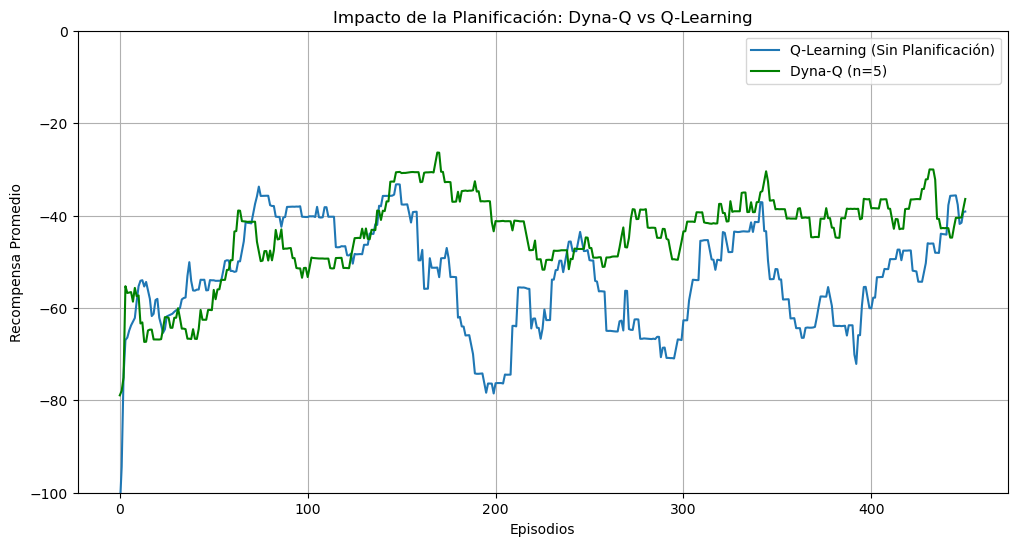

In [33]:
# Dyna-Q con 5 pasos de planificación
n_planning = 5
print(f"Ejecutando Dyna-Q (n={n_planning})...")
Q_dyna, rewards_dyna = dyna_q(env, episodes, alpha, gamma, epsilon, n_planning)

# Comparación gráfica
plt.figure(figsize=(12, 6))
plt.plot(moving_average(rewards_qlearning), label='Q-Learning (Sin Planificación)')
plt.plot(moving_average(rewards_dyna), label=f'Dyna-Q (n={n_planning})', color='green')
plt.title('Impacto de la Planificación: Dyna-Q vs Q-Learning')
plt.xlabel('Episodios')
plt.ylabel('Recompensa Promedio')
plt.legend()
plt.ylim(-100, 0)
plt.grid(True)
plt.show()

Se observa que *Dyna-Q* llega a mejores recompensas promedio en la mayor parte de los episodios, sobre todo en los finales donde ya tiene suficiente información para superar al algoritmo sin planificación.

# 5. Política de exploración *Softmax*

In [34]:
def softmax_policy(Q, state, tau=1.0):
    q_values = Q[state]
    
    # restar el max
    preferences = q_values / tau
    max_pref = np.max(preferences)
    exp_values = np.exp(preferences - max_pref)
    
    probabilities = exp_values / np.sum(exp_values)
    
    # elige acción basada en las probabilidades
    action = np.random.choice(len(q_values), p=probabilities)
    return action

# Versión modificada de SARSA usando Softmax
def sarsa_softmax(env, episodes=500, alpha=0.5, gamma=1.0, tau=1.0):
    Q = np.zeros((env.rows * env.cols, 4))
    rewards = []
    
    for _ in range(episodes):
        state = env.reset()
        action = softmax_policy(Q, state, tau)
        total_reward = 0
        done = False
        
        while not done:
            next_state, reward, done = env.step(action)
            next_action = softmax_policy(Q, next_state, tau) # Selecciona sig acción con Softmax
            
            Q[state, action] += alpha * (reward + gamma * Q[next_state, next_action] - Q[state, action])
            
            state = next_state
            action = next_action
            total_reward += reward
            if total_reward < -1000: break
            
        rewards.append(total_reward)
    return Q, rewards

Ejecutando SARSA con Softmax (tau=1.0)...


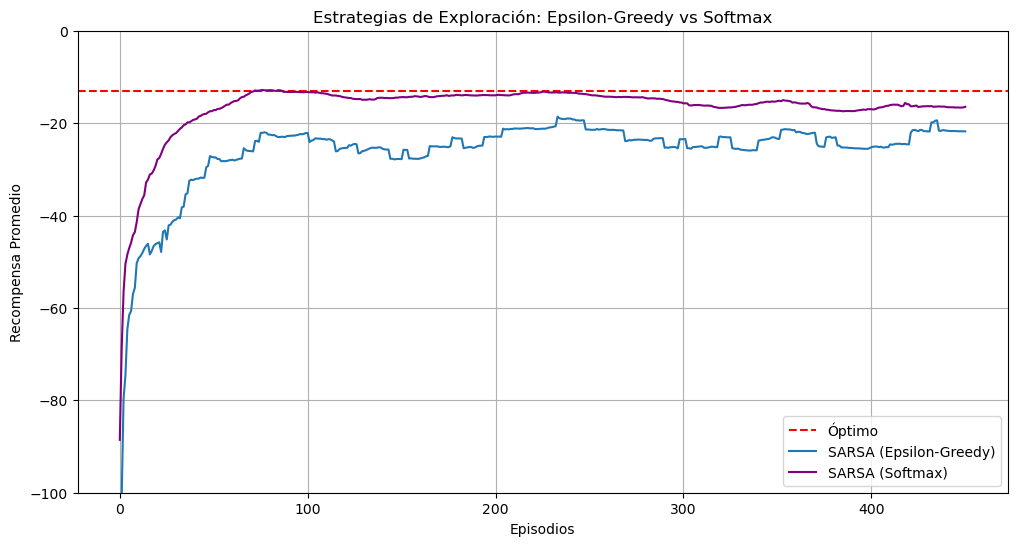

In [35]:
tau = 1.0
print(f"Ejecutando SARSA con Softmax (tau={tau})...")
Q_softmax, rewards_softmax = sarsa_softmax(env, episodes, alpha, gamma, tau)

plt.figure(figsize=(12, 6))
plt.axhline(y=-13, color='r', linestyle='--', label='Óptimo')
plt.plot(moving_average(rewards_sarsa), label='SARSA (Epsilon-Greedy)')
plt.plot(moving_average(rewards_softmax), label='SARSA (Softmax)', color='purple')
plt.title('Estrategias de Exploración: Epsilon-Greedy vs Softmax')
plt.xlabel('Episodios')
plt.ylabel('Recompensa Promedio')
plt.legend()
plt.ylim(-100, 0)
plt.grid(True)
plt.show()

Se observa que implementar la política *Softmax* no solo "suaviza" el resultado si no que el aprendizaje converge rápidamente y muy cercano al camino óptimo. Esta estrategia es más eficiente que la de *espsilon-greedy*.

# Visualización del resultado 

In [36]:
def sarsa_with_path(env, episodes, alpha, gamma, epsilon):
    Q = np.zeros((env.rows * env.cols, 4))
    episode_paths = []  # Lista de caminos (uno por episodio)

    for ep in range(episodes):
        state = env.reset()

        # Epsilon greedy
        if np.random.rand() < epsilon:
            action = np.random.choice(4)
        else:
            action = np.argmax(Q[state])

        path = []

        done = False
        while not done:
            # Registrar posición actual
            r = state // env.cols
            c = state % env.cols
            path.append((r, c))

            next_state, reward, done = env.step(action)

            # Próxima acción
            if np.random.rand() < epsilon:
                next_action = np.random.choice(4)
            else:
                next_action = np.argmax(Q[next_state])

            # SARSA update
            Q[state, action] += alpha * (reward + gamma * Q[next_state, next_action] - Q[state, action])

            state = next_state
            action = next_action

        # Registrar la última posición
        r = state // env.cols
        c = state % env.cols
        path.append((r, c))

        episode_paths.append(path)

    return Q, episode_paths


In [37]:
def qlearning_with_path(env, episodes, alpha, gamma, epsilon):
    Q = np.zeros((env.rows * env.cols, 4))
    episode_paths = []

    for ep in range(episodes):
        state = env.reset()
        done = False
        path = []

        while not done:
            # Registrar posición
            r = state // env.cols
            c = state % env.cols
            path.append((r, c))

            # Acción epsilon-greedy
            if np.random.rand() < epsilon:
                action = np.random.choice(4)
            else:
                action = np.argmax(Q[state])

            next_state, reward, done = env.step(action)

            # Q-learning update (greedy en next_state)
            Q[state, action] += alpha * (reward + gamma * np.max(Q[next_state]) - Q[state, action])

            state = next_state

        # Última posición
        r = state // env.cols
        c = state % env.cols
        path.append((r, c))

        episode_paths.append(path)

    return Q, episode_paths


In [49]:
Q_sarsa, paths_sarsa = sarsa_with_path(env, 500, alpha=0.5, gamma=1.0, epsilon=0.01)
Q_qlearning, paths_qlearning = qlearning_with_path(env, 500, alpha=0.5, gamma=1.0, epsilon=0.01)


In [47]:
def plot_path(env, path, title):
    fig, ax = plt.subplots(figsize=(6,6))

    # Dibujar grid
    ax.set_xlim(0, env.cols)
    ax.set_ylim(0, env.rows)
    ax.set_xticks(range(env.cols+1))
    ax.set_yticks(range(env.rows+1))
    ax.grid(True)

    # Dibujar acantilado
    for (r, c) in env.cliff:
        ax.add_patch(plt.Rectangle((c, env.rows - r - 1), 1, 1, color="black"))

    # Dibujar inicio
    sr, sc = env.start
    ax.add_patch(plt.Rectangle((sc, env.rows - sr - 1), 1, 1, color="green"))

    # Dibujar meta
    gr, gc = env.goal
    ax.add_patch(plt.Rectangle((gc, env.rows - gr - 1), 1, 1, color="gold"))

    # Dibujar el camino como líneas
    xs = [c + 0.5 for (r, c) in path]
    ys = [env.rows - r - 0.5 for (r, c) in path]
    ax.plot(xs, ys, '-o', markersize=6)

    ax.set_title(title)
    ax.set_aspect("equal")
    plt.show()


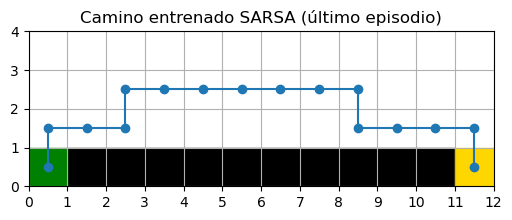

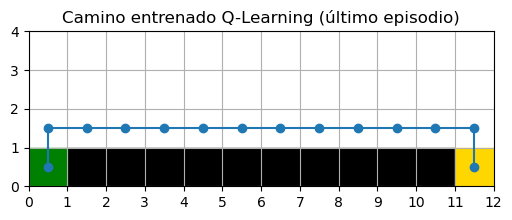

In [50]:
plot_path(env, paths_sarsa[-1], "Camino entrenado SARSA (último episodio)")
plot_path(env, paths_qlearning[-1], "Camino entrenado Q-Learning (último episodio)")


In [41]:
def sarsa_softmax_with_path(env, episodes, alpha, gamma, tau):
    Q = np.zeros((env.rows * env.cols, 4))
    episode_paths = []

    for ep in range(episodes):
        state = env.reset()

        # Acción inicial por Softmax
        action = softmax_policy(Q, state, tau)

        path = []
        done = False

        while not done:
            # Registrar posición
            r = state // env.cols
            c = state % env.cols
            path.append((r, c))

            next_state, reward, done = env.step(action)

            # siguiente acción por Softmax
            next_action = softmax_policy(Q, next_state, tau)

            # SARSA update
            Q[state, action] += alpha * (
                reward + gamma * Q[next_state, next_action] - Q[state, action]
            )

            state = next_state
            action = next_action

        # registrar último paso
        r = state // env.cols
        c = state % env.cols
        path.append((r, c))

        episode_paths.append(path)

    return Q, episode_paths


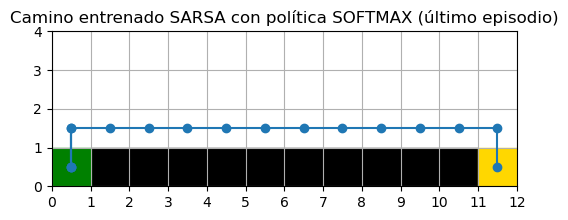

In [44]:
sarsa_softmax, paths_sarsa_softmax = sarsa_softmax_with_path(env, 500, alpha=0.5, gamma=1.0, tau=0.7)
plot_path(env, paths_sarsa_softmax[-1], "Camino entrenado SARSA con política SOFTMAX (último episodio)")
